In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy import signal
from numpy.fft import fft
import librosa, librosa.display
import soundfile as sf
import IPython.display as ipd
from librosa import stft
from numpy import conjugate, zeros_like

is_dark_mode = True
# When using Dark Reader extension at Google Chrome, I recommend using white font params.
# TODO: How can I set the suptitle color as white?
if is_dark_mode:
    params = {"ytick.color" : "w",
              "xtick.color" : "w",
              "axes.titlecolor" : "w",
              "axes.labelcolor" : "w",
              "axes.edgecolor" : "w"}
    plt.rcParams.update(params)

# POC para TCC
### Modulation Frequency Spectrogram
### Miguel Fernandes de Sousa, Universidade Federal do Rio de Janeiro, starting from April/2021.
___
This Jupyter Notebook aims to plot a simple Modulation Spectrogram Transform.

For that, this Notebook also contains the basics about plotting signals, FFTs, STFTs and finally the mod specgram.

For plotting the mod specgram, I simply apply a FFT in the absolute value from each bin from the STFT.
This FFT is made using all the points available in the STFT matrix row.

### References:
___
- Exploitation of Spectral Redundancy in Cyclostationary Signals (1991), Gardner.
- A Scalable and Progressive Audio Codec (2001), Atlas.
- Joint Acoustic and Modulation Frequency (2003), Atlas.
- Feasability of single channel speaker separation on modulation frequency analysis (2007), Schimmel & Atlas.
- Amplitude Modulation Spectrogram based features for robust speech recognition in noisy and reverberant environments (2011), Moritz.
- Fundamentals of Music Processing: Audio, Analysis, Algorithms, Applications (2016), Muller.


In [2]:
## Below, there are some functions that I reuse in most of this Notebook.

def plot_signal(signal: np.ndarray, t: np.ndarray, F_coef: np.ndarray, x_view_max_t: float, x_view_max_fft: int, suptitle: str, letter: str, x_view_min_fft: int = 0):
    """
    Plots both the time signal and its FFT.
    Parameters
    ----------
    signal: time-domain signal
    t: array w/ each time associated with each sample of the signal
    F_coef: array w/ each frequency associated with each sample of the frequency-domain signal
    x_view_max_t: max value plotted
    x_view_max_fft:  max value plotted
    suptitle: superior title of the plot
    letter: a name for the signal to be plotted. It will be printed.
    x_view_min_fft: min value plotted
    """
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'${letter}[t]$')
    plt.xlabel('t (seconds)')
    plt.axis(xmin=0, xmax=x_view_max_t)
    plt.plot(t, signal)
    plt.subplot(1, 2, 2)
    plt.title(f'$|{letter.upper()}[k]|$')
    plt.xlabel('$F_{coef}$ $[k]$ (Hz)')
    plt.plot(F_coef, abs(fft(signal)))
    plt.axis(xmin=x_view_min_fft, xmax=x_view_max_fft)
    plt.suptitle(suptitle)
    
def plot_stft(signal: np.ndarray, fs: int, title: str, max_y: int = None, n_fft: int = 2048):
    """
    Plots the STFT from the signal. The STFT here is calculated on librosa.
    Parameters
    ----------
    signal: time-domain signal
    fs: sample rate
    title: title of the graph
    max_y: max freq value
    n_fft: N points at the fft
    """
    D = librosa.stft(signal, n_fft = n_fft)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr = fs)
    ax.set(title=title)
    if max_y is not None:
        ax.set_ylim(0,max_y)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    
def stft_basic(x, w, Fs, H=8, only_positive_frequencies=True):
    """From muller FMP Notebooks. Compute a basic version of the discrete short-time Fourier transform (STFT)

    Args:
        x (np.ndarray): Signal to be transformed
        w (np.ndarray): Window function
        H (int): Hopsize (Default value = 8)
        only_positive_frequencies (bool): Return only positive frequency part of spectrum (non-invertible)
            (Default value = False)

    Returns:
        X (np.ndarray): The discrete short-time Fourier transform
    """
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int) + 1
    X = np.zeros((N, M), dtype='complex')
    for m in range(M):
        x_win = x[m * H:m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win

    if only_positive_frequencies:
        K = 1 + N // 2
        X = X[0:K, :]
        
    F_coef = np.arange(X.shape[0]) * Fs / N
    T_coef = np.arange(X.shape[1]) * H / Fs
    return (X, F_coef, T_coef)

def get_mod_specgram(x, w, Fs, H=8, only_positive_frequencies=True, max_mod=None) -> np.ndarray:
    """
    generate a modulation spectrogram, like Atlas(2003). Based on Muller implementation.
    It calculates the STFT from the time-domain signal and, for each frequency bin - represented by
    each row in the STFT matrix - , is calculated its FFT. It generates a new matrix, but now the vertical
    frames are associated with the measure oscillations inside each frequency bin in the STFT.
    """
    D, _, _ = stft_basic(x, w, Fs, H)
    N = len(D[1])
    g = np.ones(N)
    X = np.zeros((D.shape[0], N), dtype='complex')
    for m in range(X.shape[0]):
        x_win = np.abs(D[m]) * g
        X_win = np.fft.fft(x_win)
        X[m] = X_win
    
    if only_positive_frequencies:
        K = 1 + D.shape[0] // 2
        X = X[0:K, :]
        
    if max_mod is not None:
        X = X[:, 0:max_mod]
           
    F_coef = np.arange(D.shape[0]) * Fs / len(w)
    print(f'max f_coef = {D.shape[0]}, len(w) = {len(w)}, Fs = {Fs}')
    print(f'max t_coef = {D.shape[1]}, len(x) = {len(x)}, len(x)/Fs = {len(x)/Fs}, Fs = {Fs}')
    ModSR = D.shape[1] * Fs / len(x)
    print(f'ModSR = {ModSR}')
    print(f'max mod_coef = {X.shape[1]}. len(g) = {len(g)}')
#    Mod_coef = np.arange(X.shape[1]) * Fs / len(g)
#TODO: for some reason, the call above doesn't fit the shape
    Mod_coef = np.arange(X.shape[1]) * ModSR / len(g)

    if only_positive_frequencies:
        V = 1 + D.shape[1] // 2
        Mod_coef = Mod_coef[0:V]
        X = X[:, 0:V]
    return (X, F_coef, Mod_coef)

def plot_content(suptitle,x,t,Y,boundaries, is_mod=False):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(t)), x, c='k')
    plt.xlim([0, len(t)])
    plt.xlabel('Index (samples)')
    plt.subplot(1, 2, 2)
    plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r')
    plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r',extent=boundaries)
    plt.ylabel('Index (frequency) -> Hz')
    plt.suptitle(suptitle)
    if is_mod:
        plt.xlabel('Index (frequency) -> Hz')
        return
    plt.xlabel('Index (frames) -> seconds')

def get_stft_boundaries(F_coef: np.ndarray, T_coef: np.ndarray, N: int, Fs: int) -> list:
    """
    Taken from Muller. By passing the frequency and time coeficients, it returns the boundaries to be plotted.
     """
    left = min(T_coef)
    right = max(T_coef) + N / Fs
    lower = min(F_coef)
    upper = max(F_coef)
    return [left, right, lower, upper]

def get_mod_boundaries(F_coef: np.ndarray, Mod_coef: np.ndarray, g: np.ndarray, Fs: int) -> list:
    """
     Inspired by Muller. By passing the 1st order frequency and the 2nd order frequency coeficients, it returns the boundaries to be plotted.
     """
    left = min(Mod_coef)
    #right = max(Mod_coef) + len(g) / Fs
    #TODO: Still need to fix the modulation frequency plot axis.
    right = max(Mod_coef)
    lower = min(F_coef)
    upper = max(F_coef)
    return [left, right, lower, upper]

def get_row_indexes_with_most_energy(matrix, factor = 2) -> list :
    """
    It calculates the rows in a matrix with most of the energy. It's useful to search where are the
    frequency bins we want, both in STFT and on Modulation Spectrogram.
    Parameters
    ----------
    matrix: STFT or mod specgram.
    factor: threshold factor. When bigger the factor, smaller is the energy threshold.

    Returns
    -------

    """
    energies = [ np.mean(np.abs(matrix[i])) for i in range(matrix.shape[0]) ]
    return [ i for i in range(len(energies)) if energies[i] > np.max(energies) / factor]

def block_plot(x: np.ndarray, t: np.ndarray, Fs: int, w, H, title1 = 'stft', title2 = 'mod spec', only_positive_frequencies=True):
    """
    calculates, plot and returns both the STFT and the mod specgram.
    """
    X, F_coef, T_coef = stft_basic(x, w, Fs, H, only_positive_frequencies)
    ModX, _, Mod_coef = get_mod_specgram(x, w, Fs, H, only_positive_frequencies)
    #Most of the energy is condensed in the DC. You can rip off the DC by uncommenting the line below.
    #ModX[:,0] = 0;
    plot_content(title1, x,t,np.abs(X) ** 2, get_stft_boundaries(F_coef, T_coef, N, Fs))
    plot_content(title2, x,t,np.abs(ModX) ** (1. / 3), get_mod_boundaries(F_coef, Mod_coef, X[1], Fs), is_mod=True)
    return ModX, X

Below, we begin by plotting a simple time-domain signal, its FFT and its STFT. It will prepare us for what's coming next.
Notice that we generate a chirp that will act as a carrier, a low frequency signal that will modulate the carrier, and their product.

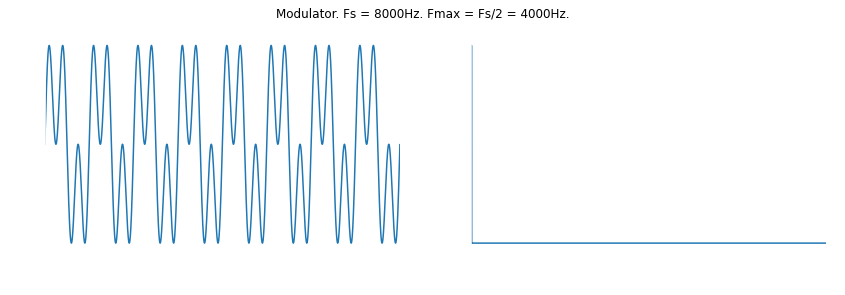

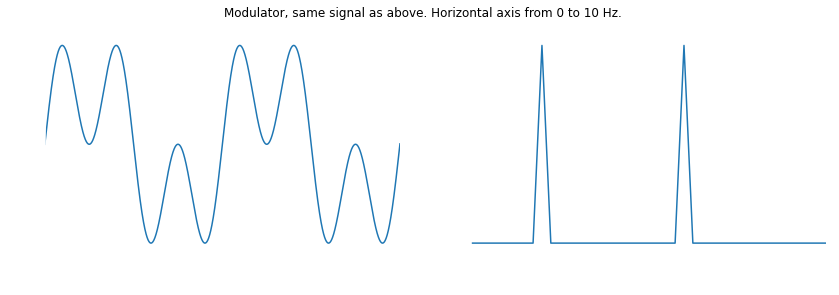

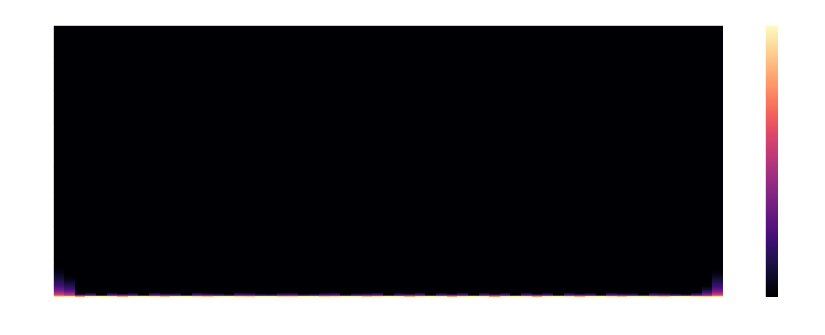

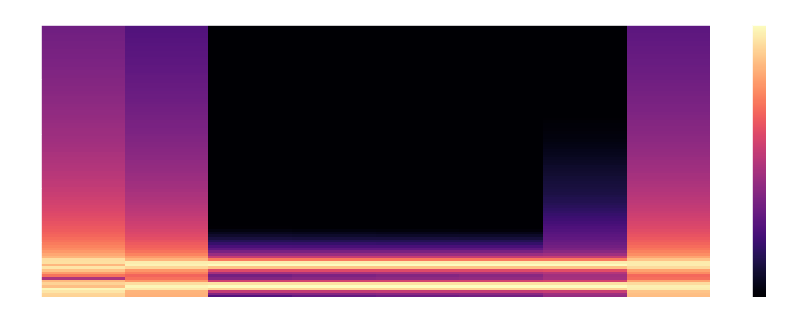

In [3]:
fs = 8000
# N = 2 * 4*fs
N = 4*fs
modFreq = 2
carrFreq = 800
t = np.arange(N) / fs

modulator = 0.1 * (np.sin(2*np.pi*modFreq*t) + np.sin(2*np.pi*3*modFreq*t))
modulator_fft = abs(fft(modulator))
M_coef = np.arange(modulator_fft.shape[0]) * fs / (N)
plot_signal(modulator, t, M_coef, 4, 4000, 'Modulator. Fs = 8000Hz. Fmax = Fs/2 = 4000Hz.', 'm')
plot_signal(modulator, t, M_coef, 1, 10, 'Modulator, same signal as above. Horizontal axis from 0 to 10 Hz.', 'm')
plot_stft(modulator, fs, 'Spectrogram $|M[k]|_{db}$, from 0 to Fs/2. 2Hz and 6Hz are there, but misses resolution.')
plot_stft(modulator, fs, 'Spectrogram $|M[k]|_{db}$, from 0 to 50 Hz.', max_y = 50, n_fft = 4096 * 4)

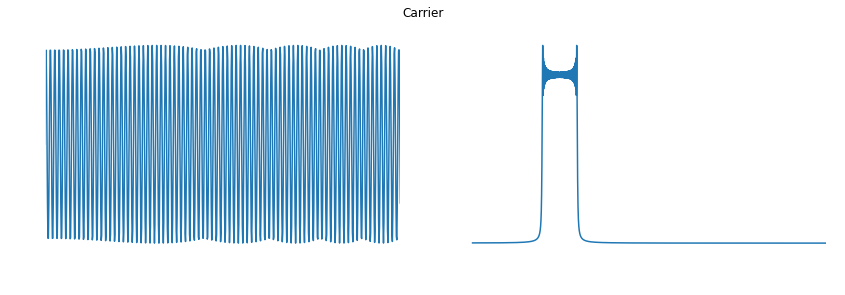

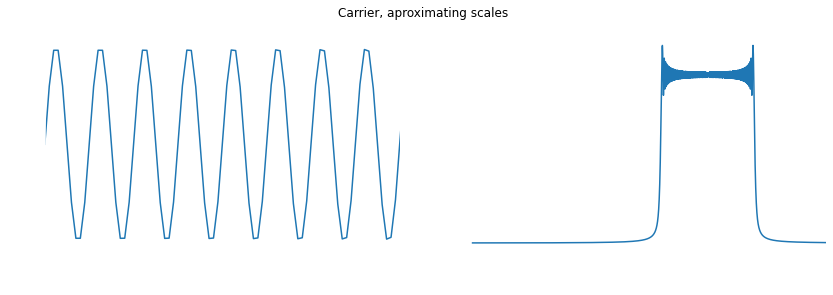

In [4]:
carrier = np.sin(2*np.pi*(carrFreq*t + 50*np.square(t)))
carrier_fft = abs(fft(carrier))
C_coef = np.arange(carrier_fft.shape[0]) * fs / (N)
plot_signal(carrier, t, C_coef, 0.1, 4000, 'Carrier', 'c')
plot_signal(carrier, t, C_coef, 0.01, 1500, 'Carrier, aproximating scales', 'c')

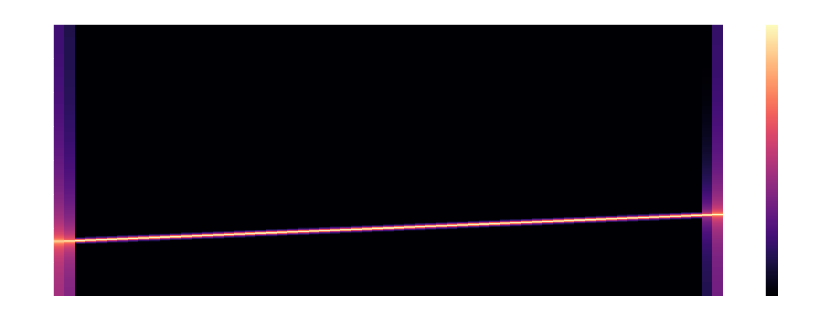

In [5]:
plot_stft(carrier, fs, '$|C[k]|_{db}$')

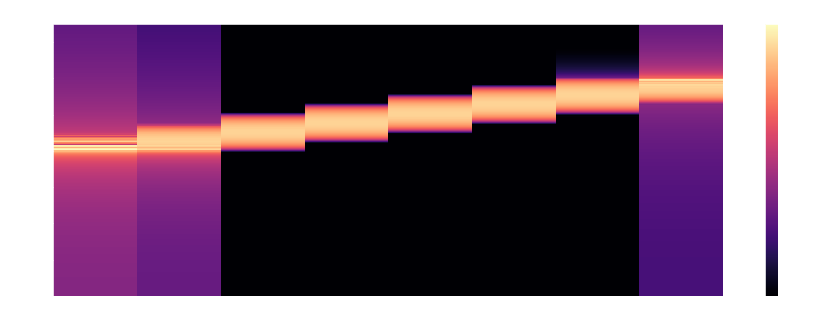

In [6]:
plot_stft(carrier, fs, '$|C[k]|_{db}$', max_y = 1500, n_fft = 4096 * 4)

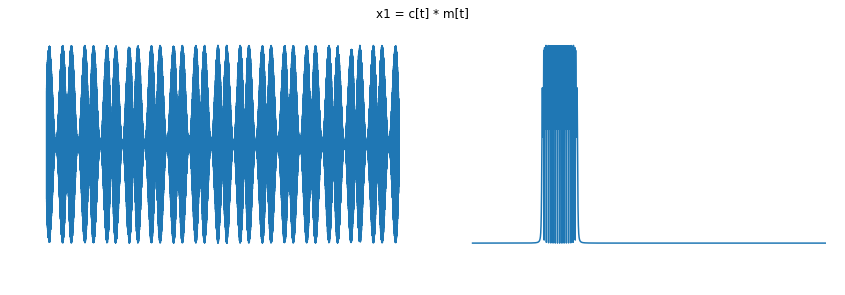

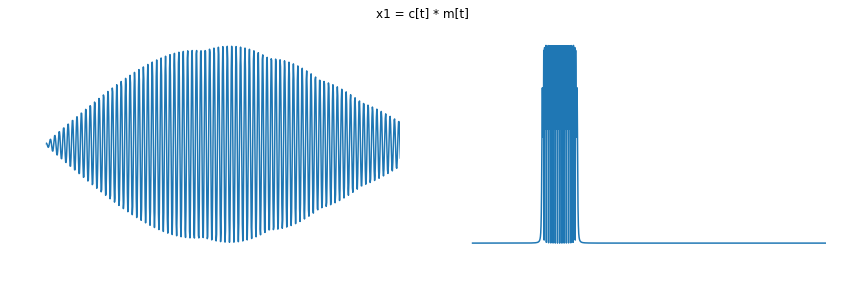

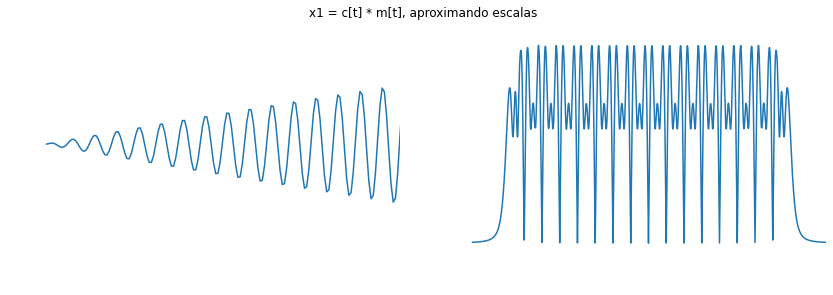

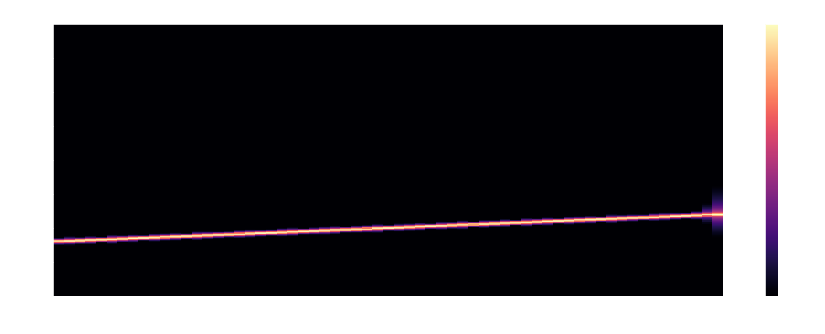

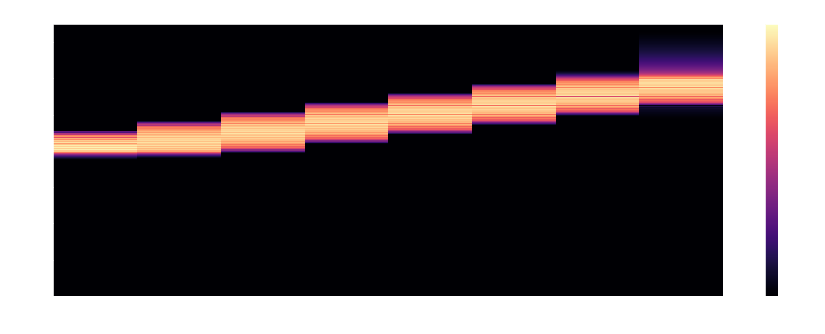

In [7]:
x1 = np.multiply(modulator, carrier)
X1 = abs(fft(x1))
X1_coef = np.arange(X1.shape[0]) * fs / (N)
plot_signal(x1, t, X1_coef, 4, 4000, 'x1 = c[t] * m[t]', 'x1')
plot_signal(x1, t, X1_coef, 0.1, 4000, 'x1 = c[t] * m[t]', 'x1')
plot_signal(x1, t, X1_coef, 0.02, 1250, 'x1 = c[t] * m[t], aproximando escalas', 'x1', x_view_min_fft=750)

plot_stft(x1, fs, '$|X1[k]|_{db}$')
plot_stft(x1, fs, '$|C[k]|_{db}$', max_y = 1500, n_fft = 4096 * 4)

# Implementation based on Muller:

Previously, we used an already built STFT by librosa. Now, we aim to plot the STFT in an explicit implementation
 made by Muller. Then, we can adapt this implementation by applying a FFT in each row, so we can plot the modulation
 spectrogram.

Below, we have a time-domain signal, its STFT and mod specgram.


max f_coef = 65, len(w) = 128, Fs = 256
max t_coef = 305, len(x) = 2560, len(x)/Fs = 10.0, Fs = 256
ModSR = 30.5
max mod_coef = 305. len(g) = 305


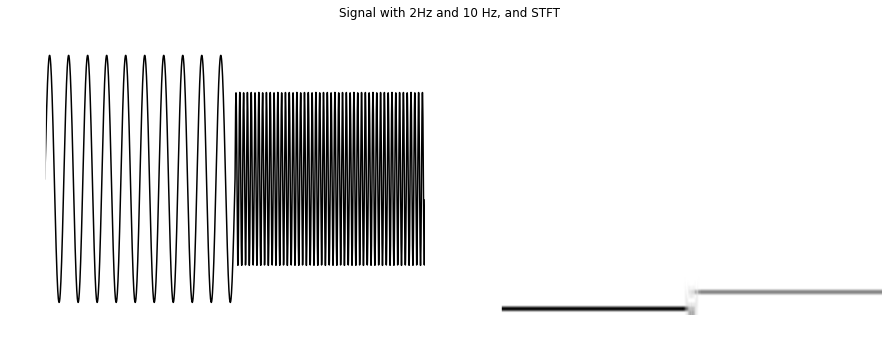

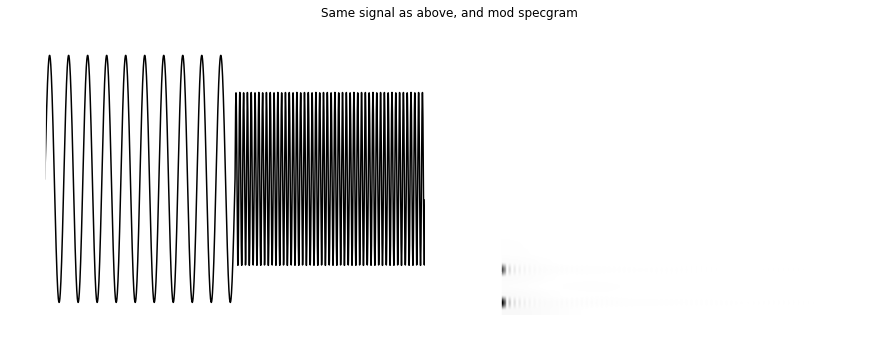

In [8]:
Fs = 256
duration = 10
omega1 = 2
omega2 = 10
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))
 
H = 8
N = 128


w = np.ones(N)
X, F_coef, T_coef = stft_basic(x, w, Fs, H, only_positive_frequencies=True)
ModX, _, Mod_coef = get_mod_specgram(x, w, Fs, H, only_positive_frequencies=True)

Y = np.abs(X) ** 2
ModY = np.abs(ModX) ** 1/4

plot_content('Signal with 2Hz and 10 Hz, and STFT', x,t,Y,get_stft_boundaries(F_coef, T_coef, N, Fs))
plot_content('Same signal as above, and mod specgram',x,t,ModY, get_mod_boundaries(F_coef, Mod_coef, X[1], Fs), is_mod=True)

### The example above is useful only for determining if the transform dimensions are correct, as well as the informed values in the plot axes.

There's a helper function to find which bins have most of the energy. It's helpful to debug what happens both in
STFT and in the mod specgram, and to check if their bins are the same.

In [9]:
result = get_row_indexes_with_most_energy(ModY, factor = 4)
print(f'Most of the energy is contained in the bins with index {result}.')

Most of the energy is contained in the bins with index [1, 5].


### Plotting rows from mod specgram that condenses most of the energy:

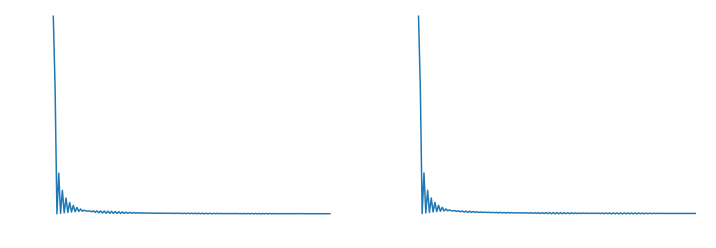

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ModY[1])
plt.subplot(1, 2, 2)
plt.plot(ModY[5])

You can notice that most of the energy is condensed in the DC value, at the first index of each horizontal frequency bin.
This is a consequence of calculating the module of each STFT frequency bin. We do
this because each X(m,k) coefficient is in the complex domain. By calculating its module, each row from the "module" STFT
acts like a real positive signal. Since this all positive signal contains oscillations offseted by a positive value, it
appears in the first vertical indexes from the plot above.

### Reminder (in portuguese):
ex:
Sinal com 200 amostras.
janela de tamanho 10, sem overlap.
STFT terá resolução de 10 frames na frequência, 20 frames no tempo.

ex2:
STFT com 10 frames na frequência, 20 frames no tempo.
Para cada frequência (ou seja, cada linha da matriz), faço uma FFT com os 20 frames no tempo.

Dessa forma, a matriz terá 10 frames das frequências originais da STFT, e 20 frames de modulação de amplitude.

Lembre de dispensar os frames com as frequências negativas antes de plotar nos gráficos.

Below, a new plot using mod specgram.

t goes from 0.0 to 3.999875
max f_coef = 1025, len(w) = 2048, Fs = 8000
max t_coef = 3745, len(x) = 32000, len(x)/Fs = 4.0, Fs = 8000
ModSR = 936.25
max mod_coef = 3745. len(g) = 3745
max f_coef = 1025, len(w) = 2048, Fs = 8000
max t_coef = 3745, len(x) = 32000, len(x)/Fs = 4.0, Fs = 8000
ModSR = 936.25
max mod_coef = 3745. len(g) = 3745
max f_coef = 1025, len(w) = 2048, Fs = 8000
max t_coef = 3745, len(x) = 32000, len(x)/Fs = 4.0, Fs = 8000
ModSR = 936.25
max mod_coef = 3745. len(g) = 3745


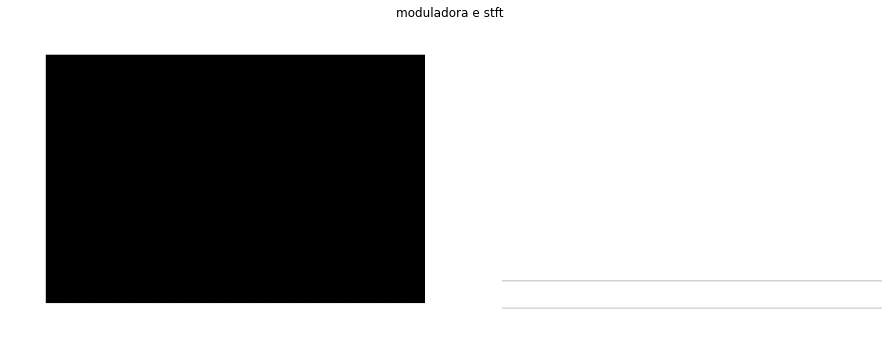

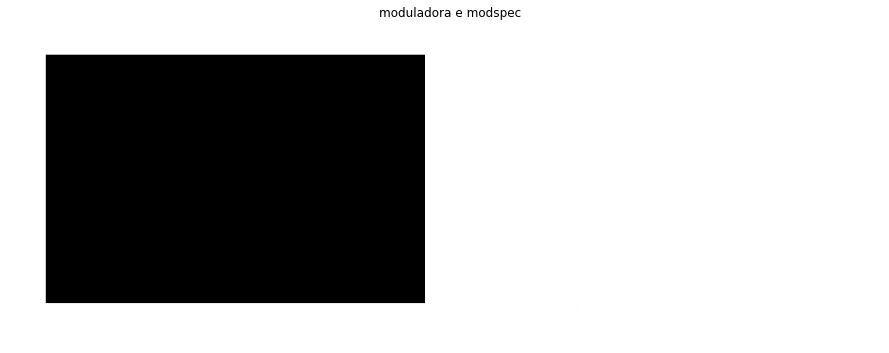

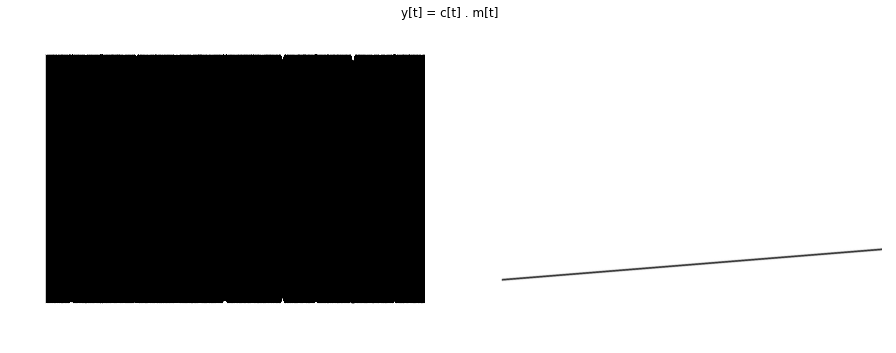

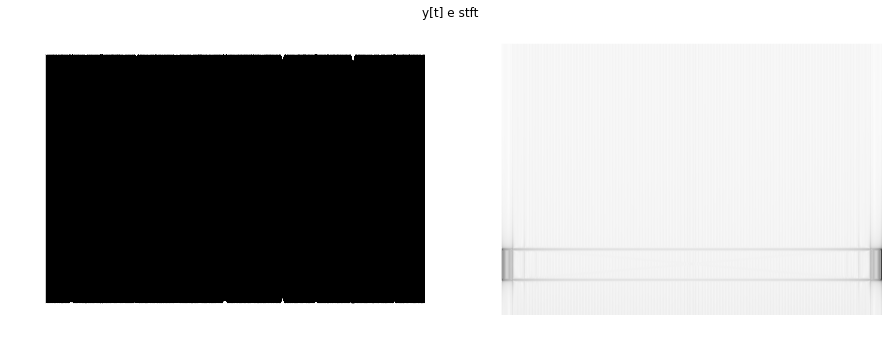

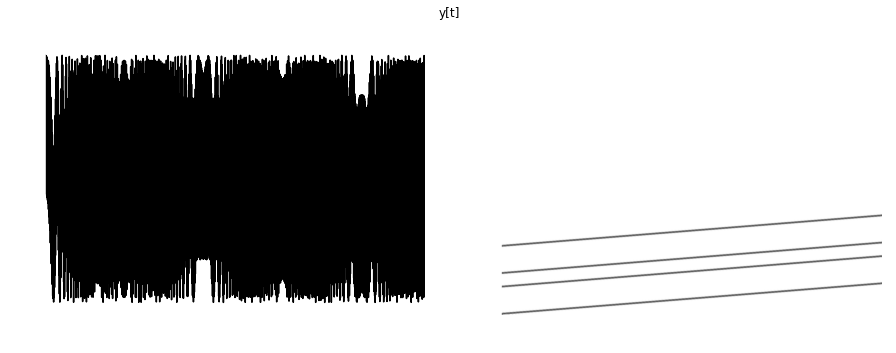

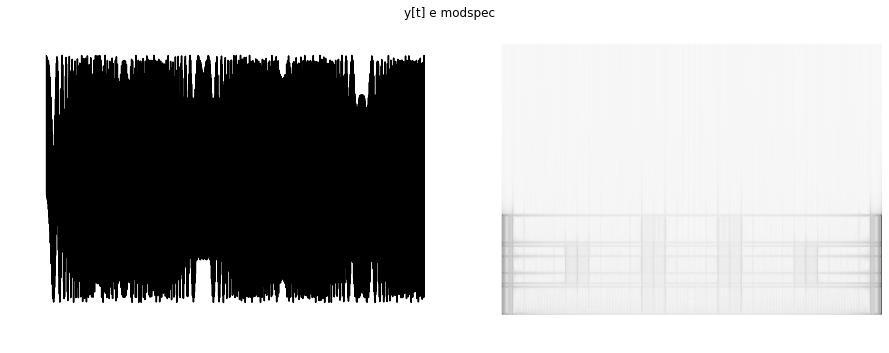

In [11]:
fs = 8000
N = 4*fs
modFreq = 100
carrFreq = 500
t = np.arange(N) / fs
print(f"t goes from {t[0]} to {t[-1]}")

modulator = 0.1 * (np.sin(2*np.pi*modFreq*t) + np.sin(2*np.pi*5*modFreq*t))
carrier = np.sin(2*np.pi*(carrFreq*t + 60*np.square(t)))
x1 = np.multiply(modulator, carrier)

H = 8
N = 2048
w = np.ones(N)

_ = block_plot(modulator, t, fs, w, H, 'moduladora e stft', 'moduladora e modspec')
_ = block_plot(carrier, t, fs, w, H, 'y[t] = c[t] . m[t]', 'y[t] e stft')
_ = block_plot(x1, t, fs, w, H, 'y[t]', 'y[t] e modspec')

You can notice that the modulation spectrogram above is not very intuitive to interpret. We can build an example with
easier interpretation below.

### Finding dots in the Modulation Spectrogram
Now, we will apply a modulation over a carrier. This modulation contains a series of low frequencies defined below.
Also, we will plot the content in all the available ways we have until now in this Jupyter Notebook, for the
 sake of due dilligence.

t goes from 0.0 to 3.9999773242630385. It has len(176400) samples
slice_size = 25200, start = 0, end = 25200
slice_size = 25200, start = 25200, end = 50400
slice_size = 25200, start = 50400, end = 75600
slice_size = 25200, start = 75600, end = 100800
slice_size = 25200, start = 100800, end = 126000
slice_size = 25200, start = 126000, end = 151200
slice_size = 25200, start = 151200, end = 176400


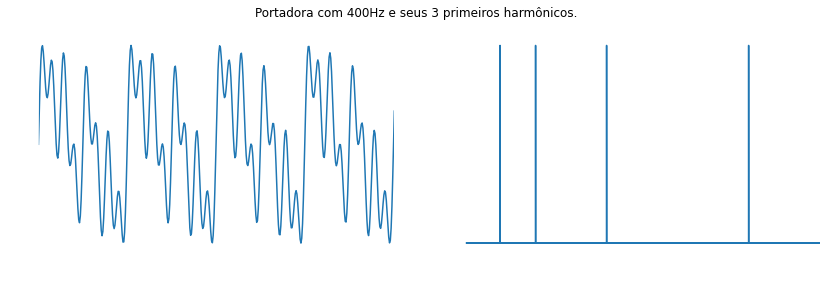

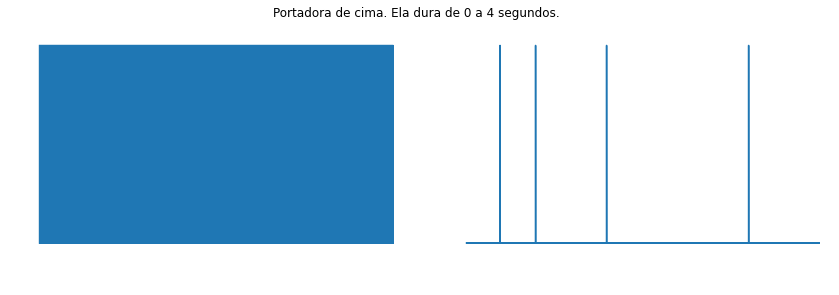

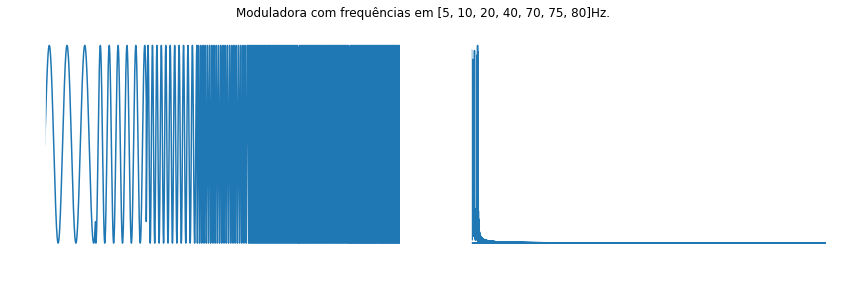

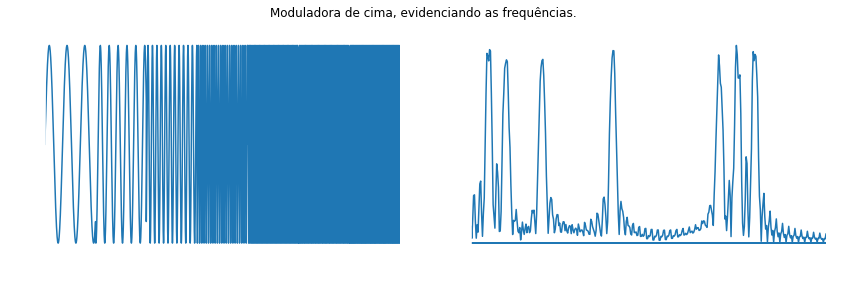

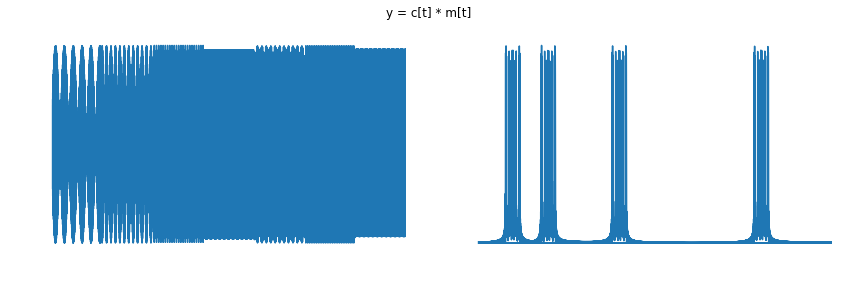

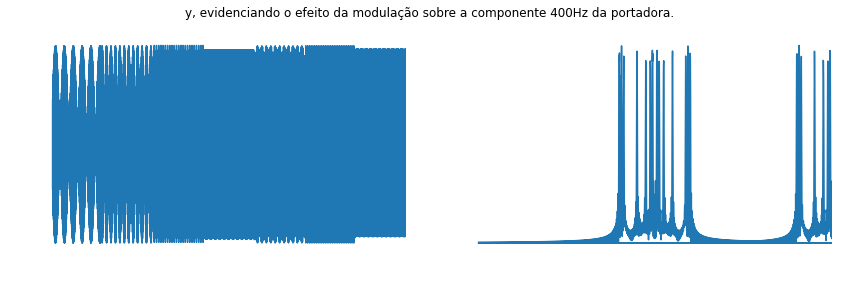

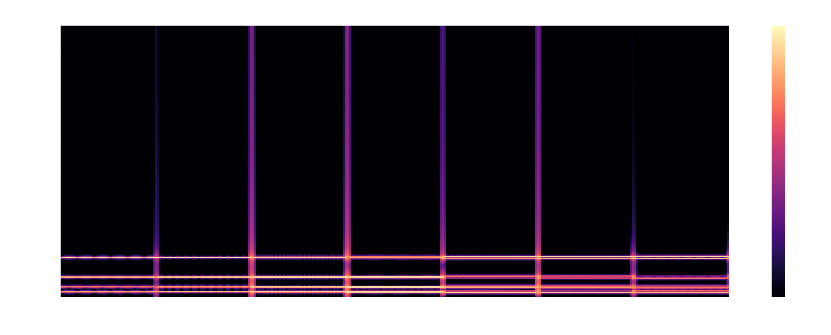

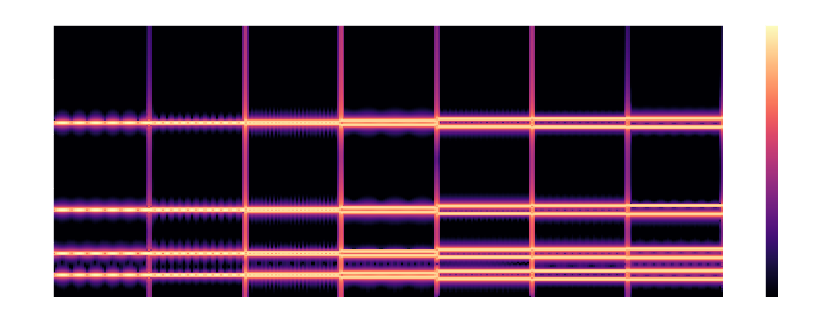

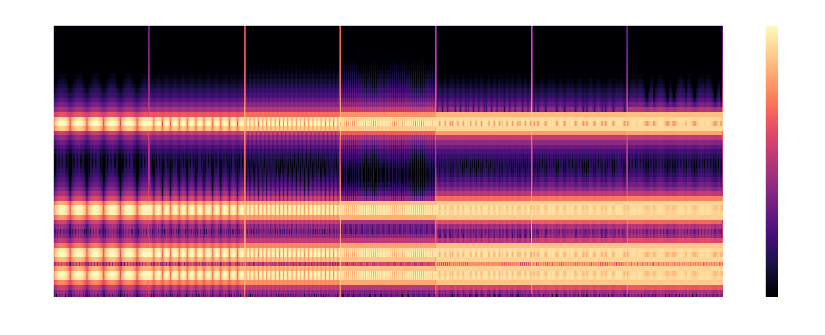

In [12]:
fs = 44100
sample_length = 4*fs
modFreq = [5, 10, 20, 40, 70, 75, 80]
carrFreq = [400, 800, 1600, 3200]
t = np.arange(sample_length) / fs
print(f"t goes from {t[0]} to {t[-1]}. It has len({sample_length}) samples")
carrier = np.zeros(shape=(len(t)))
for frequency in carrFreq:
    carrier = carrier + (1/len(carrFreq)) * np.sin(2*np.pi*frequency*t)
slice_size = int(sample_length/len(modFreq))
modulator = np.zeros(shape=(len(t)))
for index, frequency in enumerate(modFreq):
    start = slice_size * index
    end = slice_size*index + slice_size
    print(f'slice_size = {slice_size}, start = {start}, end = {end}')
    modulator[start:end] = modulator[start:end] + (1/len(modFreq)) * np.sin(2*np.pi*frequency*t[start:end])
signal = carrier * modulator
signal_fft = abs(fft(modulator))
coef = np.arange(signal.shape[0]) * fs / sample_length

plot_signal(carrier, t, coef, 0.01, 4000, 'Portadora com 400Hz e seus 3 primeiros harmônicos.', 'c')
plot_signal(carrier, t, coef, 4, 4000, 'Portadora de cima. Ela dura de 0 a 4 segundos.', 'c')
plot_signal(modulator, t, coef, 4, 4000, f'Moduladora com frequências em {modFreq}Hz.', 'm')
plot_signal(modulator, t, coef, 4, 100, 'Moduladora de cima, evidenciando as frequências.', 'm')
plot_signal(signal, t, coef, 4, 4000, 'y = c[t] * m[t]', 'y')
plot_signal(signal, t, coef, 4,800, 'y, evidenciando o efeito da modulação sobre a componente 400Hz da portadora.', 'y')
plot_stft(signal, fs, 'Espectrograma $|Y[k]|_{db}$, eixo vertical até fs/2. N_fft = 2048, duração de N_fft = 2048/44100 = 46.4ms. 1/0.0046 = 217 Hz.')
plot_stft(signal, fs, 'Espectrograma $|Y[k]|_{db}$, eixo vertical até 5KHz. N_fft = 2048, duração de N_fft = 2048/44100 = 46.4ms. 1/0.0046 = 217 Hz.', max_y = 5000)
plot_stft(signal, fs, 'Espectrograma $|Y[k]|_{db}$, eixo vertical até 5KHz. N_fft = 512.', max_y = 5000, n_fft= 512)

max f_coef = 257, len(w) = 512, Fs = 44100
max t_coef = 2749, len(x) = 176400, len(x)/Fs = 4.0, Fs = 44100
ModSR = 687.25
max mod_coef = 2749. len(g) = 2749
max f_coef = 257, len(w) = 512, Fs = 44100
max t_coef = 2749, len(x) = 176400, len(x)/Fs = 4.0, Fs = 44100
ModSR = 687.25
max mod_coef = 2749. len(g) = 2749
max f_coef = 257, len(w) = 512, Fs = 44100
max t_coef = 2749, len(x) = 176400, len(x)/Fs = 4.0, Fs = 44100
ModSR = 687.25
max mod_coef = 2749. len(g) = 2749


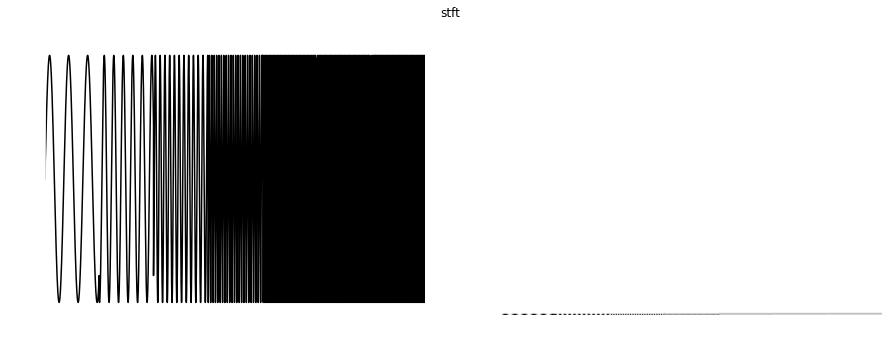

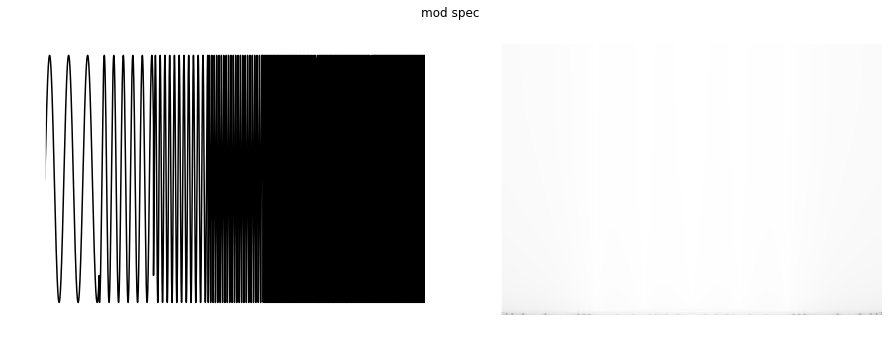

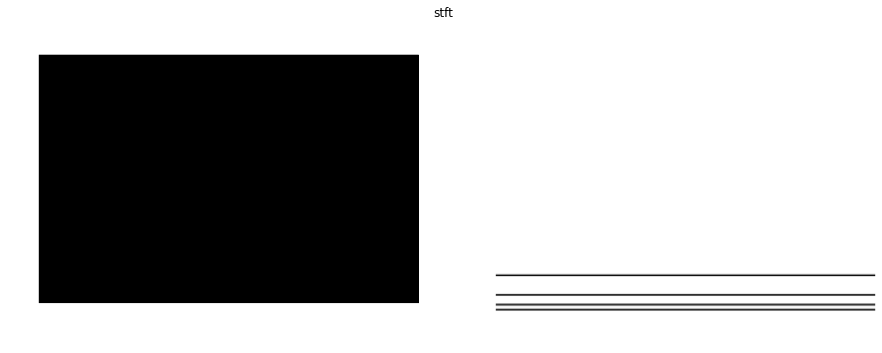

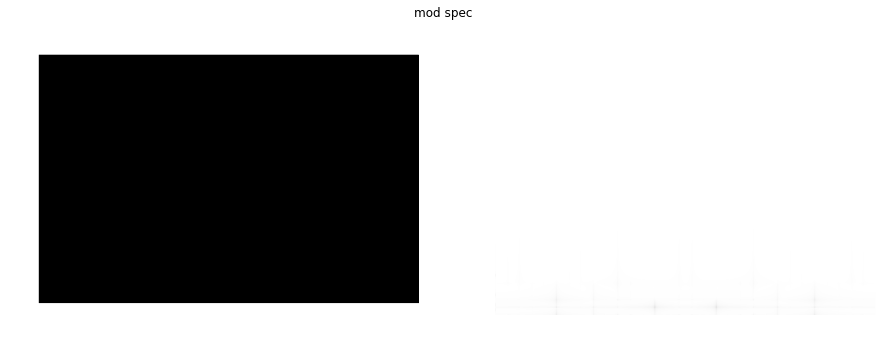

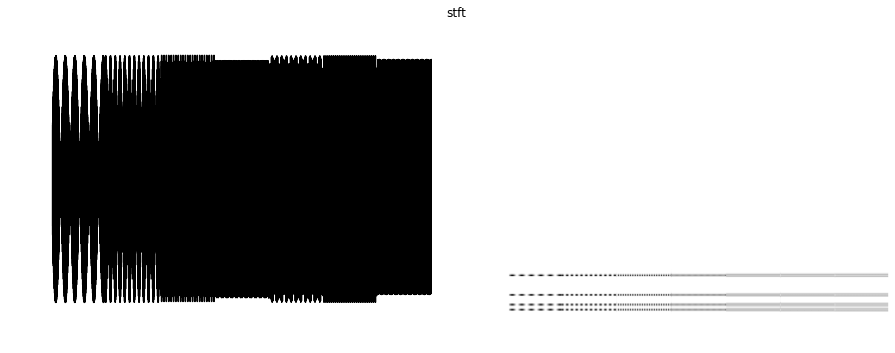

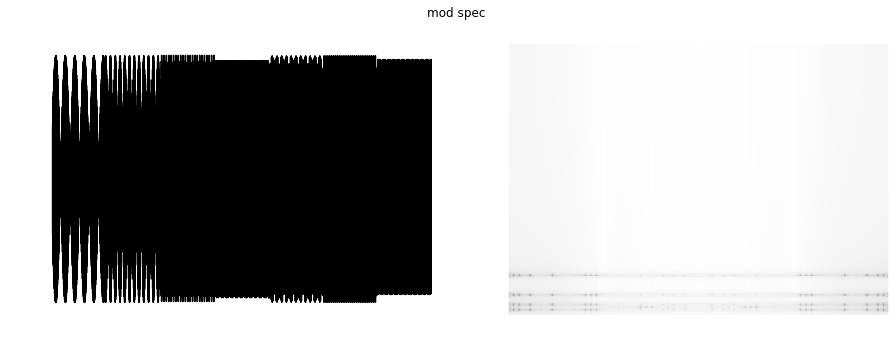

In [13]:
H = 64
N = 512
w = np.hanning(N)

_ = block_plot(modulator,t,fs,w,H)
_ = block_plot(carrier,t,fs,w,H)
ModSignal, Xsignal = block_plot(signal,t,fs,w,H)

In [14]:
print(f'high energy stft bins: {get_row_indexes_with_most_energy(Xsignal)}')
print(f'high energy mod spec bins: {get_row_indexes_with_most_energy(ModSignal)}')

high energy stft bins: [4, 5, 6, 8, 9, 10, 18, 19, 20, 36, 37, 38]
high energy mod spec bins: [4, 5, 9, 10, 18, 19, 37]


Below, I'm investigating some of these higher energy rows, and where are located the dots displayed in the mod specgram
above.
The first pair of graphs are the real and imaginary parts from a single bin in the STFT. The second pair is for another
 bin in the same STFT.
Finally, I plot the bin in the mod specgram. You can notice again how much energy is present at the DC level from the module of the
bin, represented by the first index.
The last pair plots the same bins, but ripping off the first index.

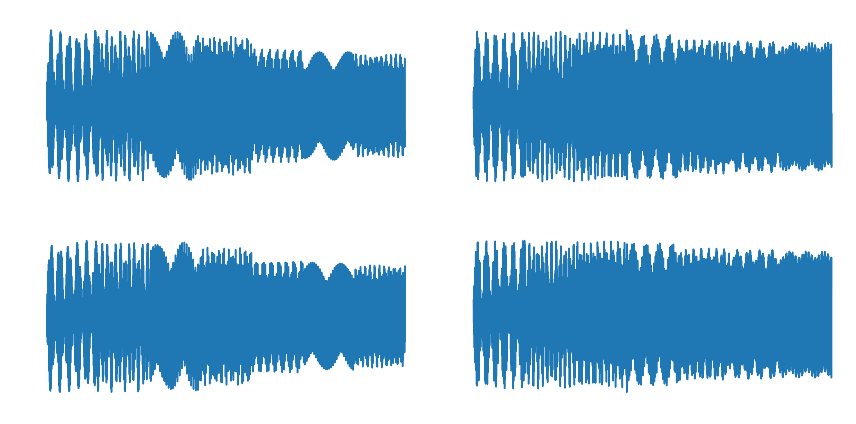

In [15]:
def plot_4_graphs(a,a_title, b, b_title, c, c_title, d, d_title):
    fig, axs = plt.subplots(2, 2, figsize=(12,6))
    axs[0, 0].set_title(a_title)
    axs[0, 0].plot(a)
    axs[0, 1].set_title(b_title)
    axs[0, 1].plot(b)
    axs[1, 0].set_title(c_title)
    axs[1, 0].plot(c)
    axs[1, 1].set_title(d_title)
    axs[1, 1].plot(d)
    fig.tight_layout()
    
plot_4_graphs(np.real(Xsignal[18][:]), '18th bin. Real part.',
              np.real(Xsignal[38][:]), '38th bin. Real part.',
              np.imag(Xsignal[18][:]), '18th bin. Imaginary part.',
              np.imag(Xsignal[38][:]), '38th bin. Imaginary part.')

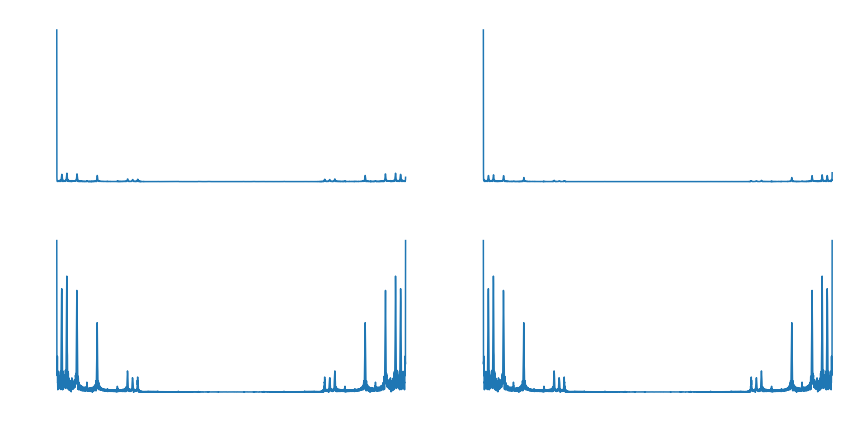

In [16]:
plot_4_graphs(abs(ModSignal[18][:]), '18th bin absolute value.',
              abs(ModSignal[38][:]), '38th bin absolute value.',
              abs(ModSignal[38][1:]), '18th bin absolute value. Without 1st sample.',
              abs(ModSignal[38][1:]), '38th bin absolute value. Without 1st sample.')


### Trumpet example
Below, we have a trumpet audio sample given by librosa. We will apply over it a low frequency modulation.
You can se a vertical line in the modulation spectrogram associated with this plot.

max f_coef = 257, len(w) = 512, Fs = 44100
max t_coef = 3668, len(x) = 235202, len(x)/Fs = 5.333378684807256, Fs = 44100
ModSR = 687.7441518354436
max mod_coef = 3668. len(g) = 3668
max f_coef = 257, len(w) = 512, Fs = 44100
max t_coef = 3668, len(x) = 235202, len(x)/Fs = 5.333378684807256, Fs = 44100
ModSR = 687.7441518354436
max mod_coef = 3668. len(g) = 3668


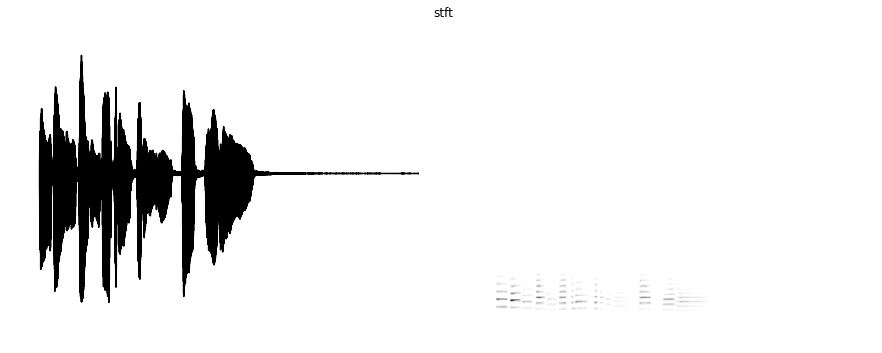

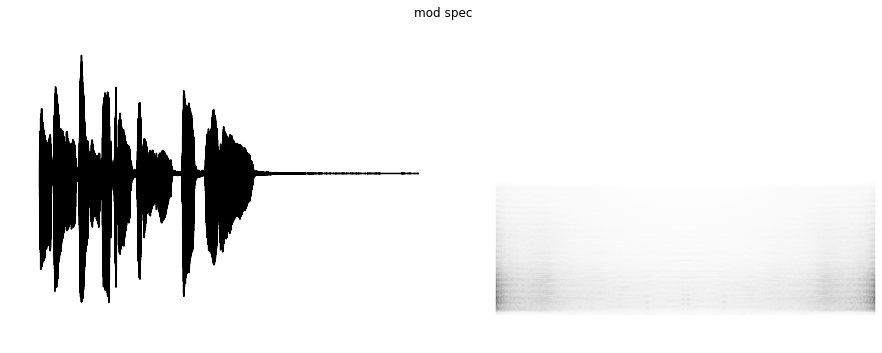

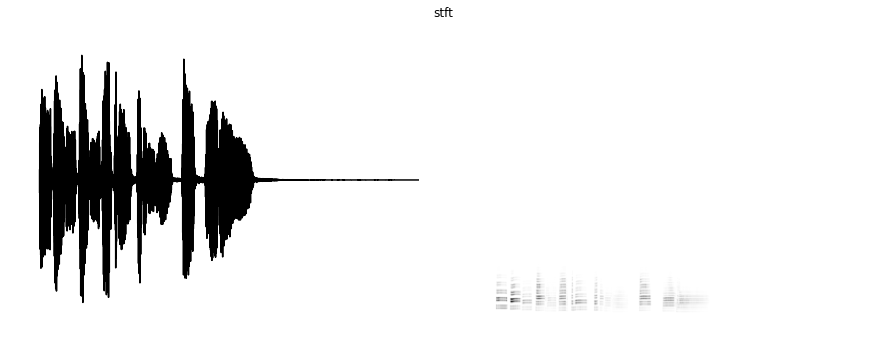

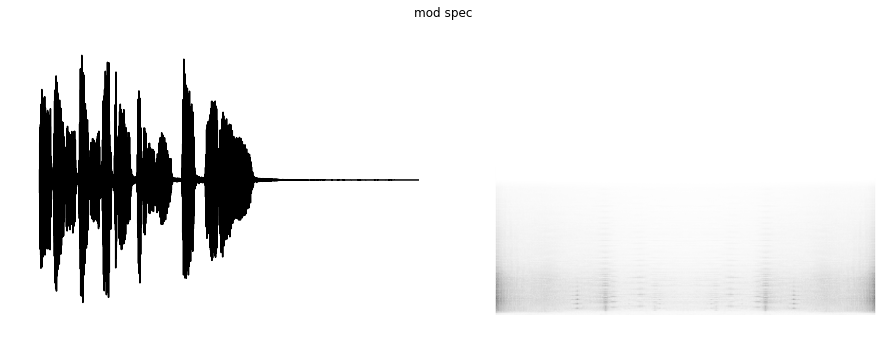

In [17]:
filename = librosa.ex('trumpet')
data, fs_origin = sf.read(filename, dtype='float32')
data = data.T
fs = 44100
data = librosa.resample(data,fs_origin, fs)
t = np.arange(len(data)) / fs
H = 64
N = 128
modulated_data = data * (np.sin(2*np.pi*100*t))
ipd.display(ipd.Audio(data, rate=fs))
ipd.display(ipd.Audio(modulated_data, rate=fs))
_ = block_plot(data,t,fs,w,H)
_ = block_plot(modulated_data,t,fs,w,H)

### Leslie amplifier example:
Below, we have an audio sample taken from an Leslie amplifier.
Observation: If you are reading this Jupyter Notebook in Github, it may not display an audio interactive player below.

max f_coef = 257, len(w) = 512, Fs = 44100
max t_coef = 16446, len(x) = 1053027, len(x)/Fs = 23.87816326530612, Fs = 44100
ModSR = 688.7464423989129
max mod_coef = 16446. len(g) = 16446


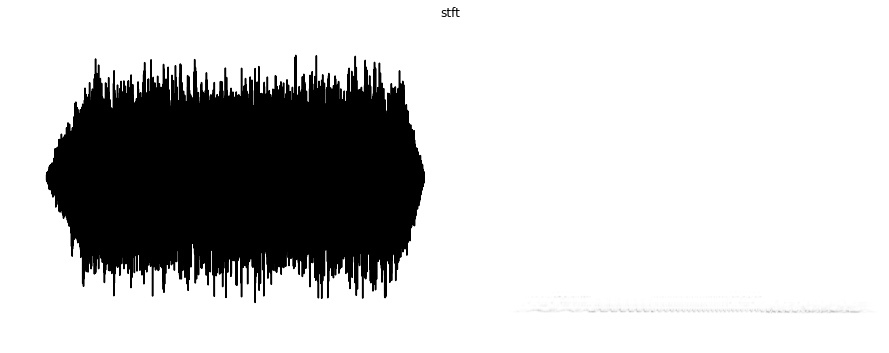

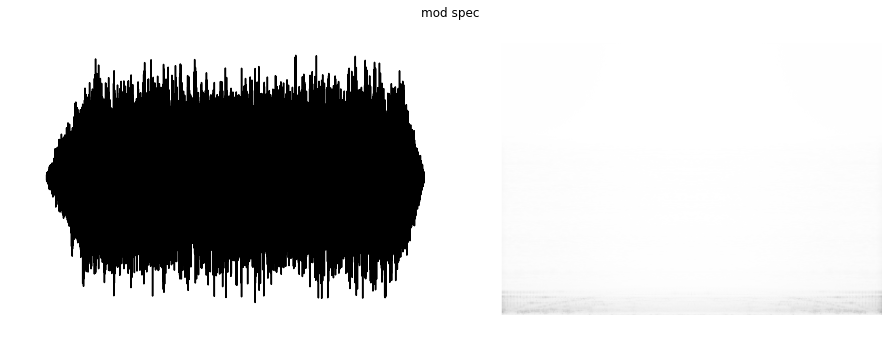

In [18]:
data, sr = sf.read('../samples/leslie.wav')
data = (data[:,0] + data[:,1]) / 2
t = np.arange(len(data)) / fs
H = 64
ipd.display(ipd.Audio(data, rate=fs))
_ = block_plot(data,t,fs,w,H)

### Future work and Conclusions:
- I still need to figure out why the horizontal axis in the mod specgram is with wrong values.
- Most of the references work with low frequencies (like 2Hz) in the mod specgram. How can I get such a viable resolution
for these very low frequency values?
- I'm missing a documentation that explains how to code it.